In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SLCP experiment

In [4]:
from simulators import SLCP
from datasets import LTEDataset
from models import Flatten, MNRE
from criterions import WeightedLoss, RELoss, RDLoss
from samplers import TractableSampler, NRESampler
from histograms import pairhist, corner

## Simulator 

In [5]:
simulator = SLCP().to(device)
simulator.sample()

(tensor([-0.2167,  2.4876,  1.5440, -1.3227,  2.0029], device='cuda:0'),
 tensor([[ 0.7863,  2.6416],
         [ 1.8837,  3.1013],
         [ 0.6626,  3.7169],
         [-1.0601,  2.2620]], device='cuda:0'))

In [6]:
trainset = LTEDataset(simulator)

## Model

In [7]:
subsets = torch.eye(5).bool()
subsets

tensor([[ True, False, False, False, False],
        [False,  True, False, False, False],
        [False, False,  True, False, False],
        [False, False, False,  True, False],
        [False, False, False, False,  True]])

In [8]:
joint_subsets = torch.tensor([
    [False, False, False, True, True],
    [False, False, True, True, True],
    [True, True, True, True, True]
])

joint_subsets

tensor([[False, False, False,  True,  True],
        [False, False,  True,  True,  True],
        [ True,  True,  True,  True,  True]])

In [9]:
model = MNRE(masks=joint_subsets, encoder=Flatten((4, 2)), num_layers=10, hidden_size=256, activation=nn.SELU).to(device)
criterion = RELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=5e-1, patience=5, threshold=1e-2, verbose=True)

### Train

In [10]:
model.train()

epoch = 0
epoch_size = 256

losses = []

for thetas, xs, mask in trainset:
    ratios = model(thetas, xs)
    loss = criterion(ratios, mask)

    losses.append(loss.tolist())

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()

    if len(losses) == epoch_size:
        losses = torch.tensor(losses)

        print(f'{epoch}: {losses.mean()} +- {losses.std()}')
        scheduler.step(losses.mean())

        epoch += 1
        losses = []

        if optimizer.param_groups[0]['lr'] < 1e-6:
            break

torch.save(model.state_dict(), 'mnre.pth')

0: 1.9506487846374512 +- 0.38103392720222473
1: 1.8951224088668823 +- 1.1485021114349365
2: 2.164458990097046 +- 1.7937521934509277
3: 2.087101936340332 +- 1.7240571975708008
4: 1.9874939918518066 +- 1.6213626861572266
5: 1.9206490516662598 +- 1.549320936203003
6: 1.809953212738037 +- 1.4132798910140991
7: 1.6557111740112305 +- 1.200960636138916
8: 1.6120160818099976 +- 1.1554096937179565
9: 1.5562939643859863 +- 1.0962053537368774
10: 1.4938806295394897 +- 1.0105680227279663
11: 1.4281827211380005 +- 0.9274521470069885
12: 1.284656047821045 +- 0.7375679612159729
13: 1.2344576120376587 +- 0.6853034496307373
14: 1.1429831981658936 +- 0.5120461583137512
15: 1.084384560585022 +- 0.40528082847595215
16: 1.036666750907898 +- 0.3218454122543335
17: 1.0383782386779785 +- 0.34664487838745117
18: 1.0260639190673828 +- 0.32033252716064453
19: 1.0019279718399048 +- 0.27730613946914673
20: 1.0023479461669922 +- 0.28660228848457336
21: 0.9821885824203491 +- 0.26556456089019775
22: 0.933857977390289

In [11]:
model.load_state_dict(torch.load('mnre.pth', map_location=device))

<All keys matched successfully>

## Metropolis-Hastings

In [12]:
theta_star = torch.tensor([0.7, -2.9, -1., -0.9,  0.6]).to(device)
x_star = torch.tensor([
    [-0.48406151, -3.13977371],
    [-0.43098274, -3.50238278],
    [-0.03512463, -2.87554796],
    [ 1.43279532, -2.80650507]
]).to(device)

In [13]:
x_star = x_star.expand((2 ** 12,) + x_star.shape)

### MNRE

In [14]:
model.eval()
z_star = model.encoder(x_star)

In [15]:
mask, nre = model[1]

In [16]:
labels = [f'$\\theta_{{{i}}}$' for (i, m) in enumerate(mask, 1) if m]

low = simulator.low[mask].cpu().numpy()
high = simulator.high[mask].cpu().numpy()

In [17]:
sampler = NRESampler(simulator.subprior(mask), nre, z_star, sigma=0.1)
hists = pairhist(sampler(4096), low, high, bins=60, normed=True, bounded=True)

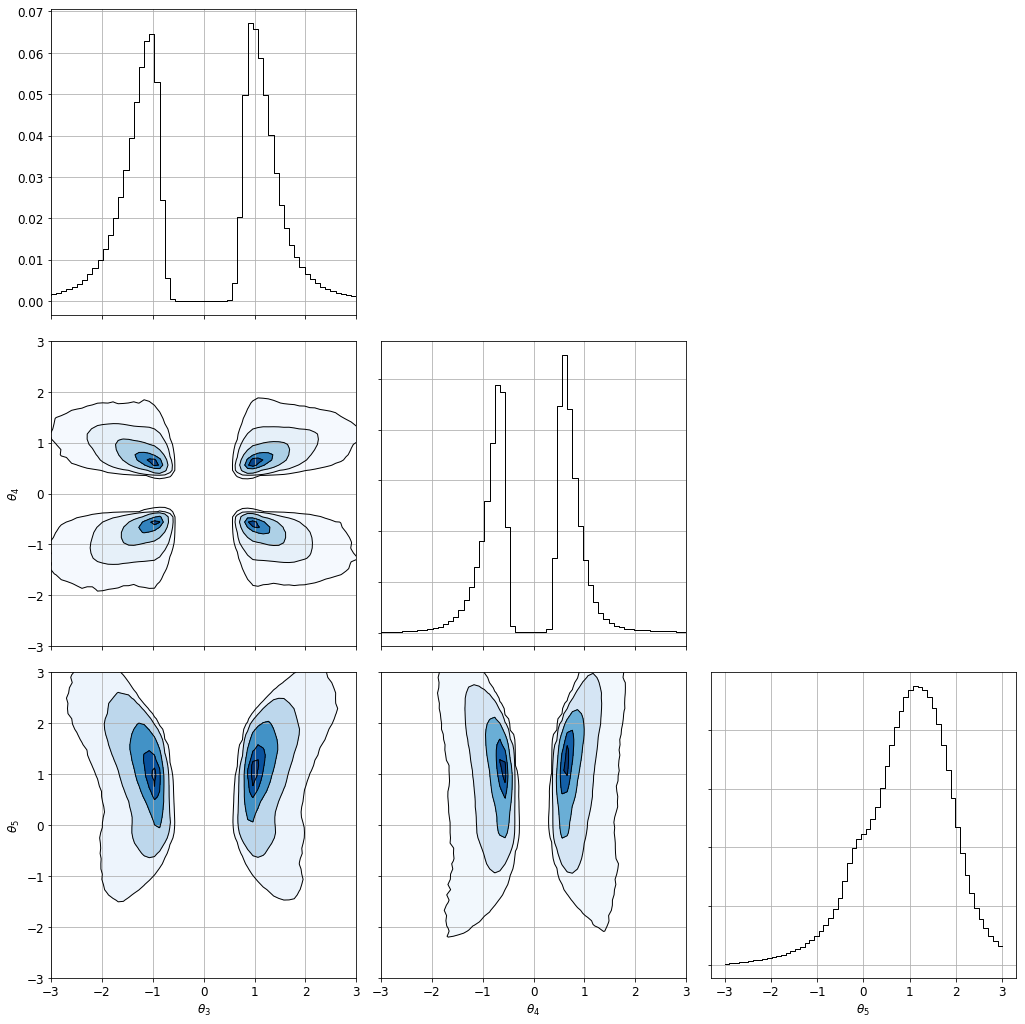

In [18]:
fig = corner(hists, low, high, labels=labels)